In [59]:
import chess.pgn

FILENAME = "lichess_db_standard_rated_2014-10.pgn"

# # Open your PGN file
# with open(file_name, "r") as pgn_file:
#     while True:
#         game = chess.pgn.read_game(pgn_file)
#         if game is None:
#             break  # End of file

#         board = game.board()
#         for move in game.mainline_moves():
#             print(board.fen())
#             print("Move:", board.san(move))
#             board.push(move)

with open(FILENAME) as pgn_file:
    first_game = chess.pgn.read_game(pgn_file)

board = first_game.board()

for move in first_game.mainline_moves():
    print(board.san(move))  # Print move in algebraic notation
    board.push(move)

d4
e6
c4
d5
Nc3
dxc4
e4
c6
Bxc4
Nf6
e5
Nd5
Nxd5
cxd5
Bb3
a6
f4
Nc6
Nf3
b5
Be3
Bb7
O-O
Na5
Bc2
Nc4
Bc1
Be7
Qd3
O-O
Qxh7#


In [6]:
print(board)

r . . q . r k .
. b . . b p p Q
p . . . p . . .
. p . p P . . .
. . n P . P . .
. . . . . N . .
P P B . . . P P
R . B . . R K .


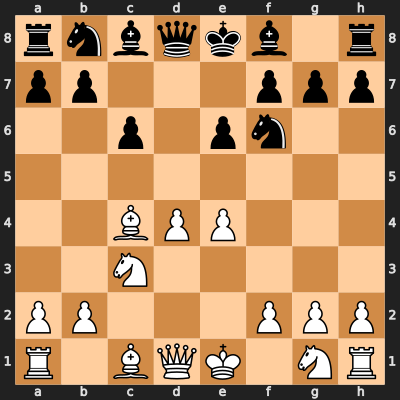

In [57]:
from IPython.display import SVG

# Show final position of the first game
SVG(chess.svg.board(board))
#resize the board to smaller size
SVG(chess.svg.board(board, size=400))

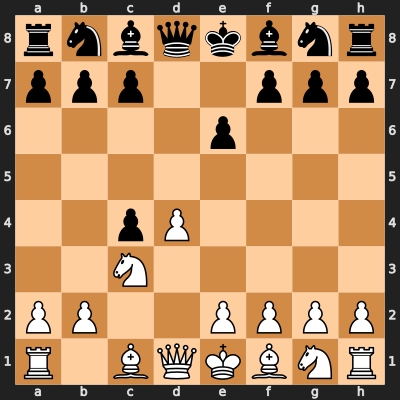

In [84]:
board = first_game.board()
for i, move in enumerate(first_game.mainline_moves()):
    board.push(move)
    if i == 5:
        break  # show board after 10 moves

SVG(chess.svg.board(board, size=400))

# Ratings Histogram

1000000it [00:01, 911575.34it/s]
Exception ignored in: <generator object pgn_text_game_generator at 0x130407de0>
Traceback (most recent call last):
  File "/var/folders/xb/0_m2vys15615hn4xqm0k1_7m0000gn/T/ipykernel_32495/2962771306.py", line 24, in <module>
RuntimeError: generator ignored GeneratorExit


Number of games with players rated above 2000: 66480
Number of games with players rated above 2200: 12700


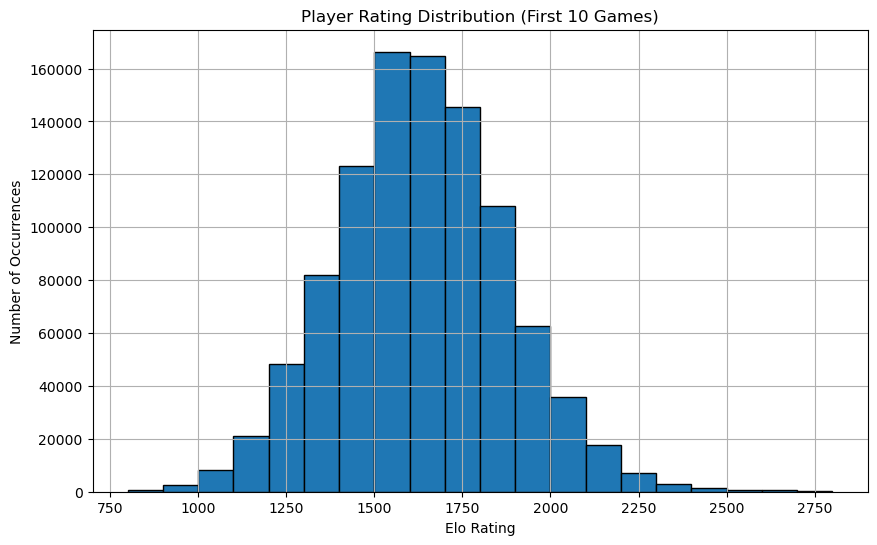

In [ ]:
def pgn_text_game_generator(file_path):
    with open(file_path) as f:
        game_lines = []
        for line in f:
            # only yield lines starting with [WhiteElo "..."] or [BlackElo "..."]

            if line.startswith("[WhiteElo") or line.startswith("[BlackElo"):
                try:
                # extract the rating from the line
                    rating = int(re.search(r'\d+', line).group())
                    yield rating
                
                except:
                    continue


# Example: Extract ratings without using python-chess
import re

ratings = []
RATED_ABOVE_2200 = 0
RATED_ABOVE_2000 = 0

for rating in tqdm(zip(pgn_text_game_generator(FILENAME), range(1000000))):
    if rating[0] >= 2000:
        RATED_ABOVE_2000 += 1
        if rating[0] >= 2200:
            RATED_ABOVE_2200 += 1

    ratings.append(rating[0])
    #print(rating[0])

print(f"Number of games with players rated above 2000: {RATED_ABOVE_2000}")
print(f"Number of games with players rated above 2200: {RATED_ABOVE_2200}")

# plot histogram of ratings

plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=range(800, 2801, 100), edgecolor='black')
plt.title("Player Rating Distribution (First 10 Games)")
plt.xlabel("Elo Rating")
plt.ylabel("Number of Occurrences")
plt.grid(True)
plt.show()

In [93]:
import itertools
        
def pgn_text_game_generator2(file_path):
    with open(file_path) as f:
        game_lines = []
        for line in f:
            # only yield lines starting with [WhiteElo "..."] or [BlackElo "..."]
            if line.startswith("[Event"):
                yield line

def game_generator(file_path, n=None):
    if n is None:
        yield from pgn_text_game_generator2(file_path)
    else:
        yield from itertools.islice(pgn_text_game_generator2(file_path), n)

# count games

game_count = 0
for game in tqdm(game_generator(FILENAME)):
    game_count += 1

print(f"Number of games in the PGN file: {game_count}")

1111302it [00:01, 813326.22it/s]

Number of games in the PGN file: 1111302


# Creating position tensors

In [62]:
import torch
import chess
import chess.pgn

def piece_to_index(piece):
    """Map a chess.Piece to index 0–11 (or None for empty)."""
    if piece is None:
        return None
    offset = 0 if piece.color == chess.WHITE else 6
    return offset + piece.piece_type - 1  # piece_type in 1..6

def board_to_tensor(board):
    tensor = torch.zeros(8, 8, 18)  # (rows, cols, channels)

    # Piece planes (12)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        idx = piece_to_index(piece)
        if idx is not None:
            row, col = divmod(square, 8)
            tensor[row, col, idx] = 1

    # Side to move (1)
    stm_channel = 12
    if board.turn == chess.WHITE:
        tensor[:, :, stm_channel] = 1  # broadcast over all squares

    # # Castling rights (4)
    # castling_rights = {
    #     chess.WHITE: [chess.KING_SIDE, chess.QUEEN_SIDE],
    #     chess.BLACK: [chess.KING_SIDE, chess.QUEEN_SIDE],
    # }
    # castling_channels = [13, 14, 15, 16]
    # for i, (color, sides) in enumerate(castling_rights.items()):
    #     for j, side in enumerate(sides):
    #         if board.has_castling_rights(color) and board.has_kingside_castling_rights(color) if side == chess.KING_SIDE else board.has_queenside_castling_rights(color):
    #             tensor[:, :, castling_channels[2*i + j]] = 1

    # Castling rights (4)
    castling_channels = [13, 14, 15, 16]
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[:, :, castling_channels[0]] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[:, :, castling_channels[1]] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[:, :, castling_channels[2]] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[:, :, castling_channels[3]] = 1

    # En passant square (1)
    ep_channel = 17
    ep_square = board.ep_square
    if ep_square is not None:
        row, col = divmod(ep_square, 8)
        tensor[row, col, ep_channel] = 1

    return tensor

def game_to_tensor_sequence(game):
    """Returns a tensor of shape (m, 8, 8, 18) for a single game."""
    board = game.board()
    positions = []
    for move in game.mainline_moves():
        board.push(move)
        tensor = board_to_tensor(board)
        positions.append(tensor)
    return torch.stack(positions)  # (m, 8, 8, 18)

In [78]:
X = game_to_tensor_sequence(first_game)
print(X.shape)
X[0, :, :, 11]  # side to move

torch.Size([31, 8, 8, 18])


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])

In [9]:
# import ChessTransformer
# read config from engine_config.yaml
import yaml
from src.engine import ChessTransformer

with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)


for key, value in config["model"].items():
    print(key, ":", value)

engine = ChessTransformer(config["model"])

embed_dim : 128
num_heads : 8
dropout : 0.1
mlp_ratio : 4
eval_hidden_dim : 128
num_layers : 12


In [10]:
# number of parameters in engine
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(engine):,}")

Number of parameters in the model: 3,199,617


In [124]:
model = engine.blocks[0]

# count parameters in model

print(f"Number of parameters in the first transformer block: {count_parameters(model):,}")


Number of parameters in the first transformer block: 461,568


In [6]:
from chessengine.loss_heads import InCheckLoss
import torch

B = 4  # batch size
x = torch.randn(B, 65, 20)  # random input tensor
king_square = torch.randint(0, 64, (B,1))  # random king squares
in_check = torch.randint(0, 2, (B,1))  # random in-check flags

print(f'{in_check.dtype = }')

config = {"embed_dim": 20}

loss_fn = InCheckLoss(config)
loss1, loss2 = loss_fn(x, king_square, in_check.float())
print(loss1)
print(loss2)  

# board_x = x[:, 1:, :]  # Remove the [EVAL] token — shape becomes (B, 64, H)
# print(f'{board_x.shape=}')

# index = king_square.unsqueeze(-1).expand(-1, -1, board_x.size(-1))  # (B, 1, H)
# print(f'{index.shape=}')

# king_repr = board_x.gather(dim=1, index=index)  # (B, 1, H)
# print(f'{king_repr.shape=}')

in_check.dtype = torch.int64
tensor(0.6789, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[ 0.0934],
        [ 0.0061],
        [-0.1649],
        [-0.1257]], grad_fn=<SqueezeBackward1>)


In [17]:
from chessengine.dataclass import ChessPositionDataset

data = ChessPositionDataset(["../chess_engine/data/positions_short3.pt"])

In [18]:
len(data)

4346

In [20]:
N = 4346 
T = 16 # seconds

games = 1000000
positions = games * 100

time = T * positions / N
time_m = time / 60  # convert to minutes
time_h = time / 3600  # convert to hours
print(f"Time to train on {positions} positions: {time:.2f} seconds")
print(f"Time to train on {positions} positions: {time_m:.2f} minutes")
print(f"Time to train on {positions} positions: {time_h:.2f} hours")

Time to train on 100000000 positions: 368154.62 seconds
Time to train on 100000000 positions: 6135.91 minutes
Time to train on 100000000 positions: 102.27 hours


# NEW DATABASE - ABOVE 2400 RATINGS

In [33]:
def print_first_games(pgn_path, n_games=3):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        count = 0
        for line in f:
            if line.startswith("[Event "):
                if game_lines:
                    print("".join(game_lines))
                    print("=" * 80)
                    count += 1
                    if count >= n_games:
                        break
                game_lines = [line]
            else:
                game_lines.append(line)

# Example usage:
print_first_games("filtered_2400.pgn", n_games=3)

[Event "Rated Bullet game"]
[Site "https://lichess.org/OQPdf60o"]
[Date "2025.02.01"]
[Round "-"]
[White "PSti"]
[Black "arturogonzalez"]
[Result "0-1"]
[UTCDate "2025.02.01"]
[UTCTime "00:00:05"]
[WhiteElo "2462"]
[BlackElo "2416"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[BlackTitle "CM"]
[ECO "A10"]
[Opening "English Opening"]
[TimeControl "60+0"]
[Termination "Normal"]

1. c4 { [%clk 0:01:00] } 1... d6 { [%clk 0:01:00] } 2. g3 { [%clk 0:01:00] } 2... Nf6 { [%clk 0:01:00] } 3. Bg2 { [%clk 0:01:00] } 3... g6 { [%clk 0:00:59] } 4. Nf3 { [%clk 0:00:59] } 4... Bg7 { [%clk 0:00:59] } 5. Nc3 { [%clk 0:00:59] } 5... O-O { [%clk 0:00:59] } 6. O-O { [%clk 0:00:58] } 6... c6 { [%clk 0:00:59] } 7. d4 { [%clk 0:00:58] } 7... d5 { [%clk 0:00:58] } 8. cxd5 { [%clk 0:00:57] } 8... cxd5 { [%clk 0:00:58] } 9. Ne5 { [%clk 0:00:56] } 9... Nc6 { [%clk 0:00:55] } 10. Nxc6 { [%clk 0:00:55] } 10... bxc6 { [%clk 0:00:55] } 11. Bg5 { [%clk 0:00:55] } 11... Bf5 { [%clk 0:00:54] } 12. Na4 { [%clk 0:00:54

## Games with evaluation

In [31]:
def check_if_eval_exists(pgn_path, max_games=None):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        count = 0
        for line in f:
            if line.startswith("[Event "):
                total_games += 1
                if game_lines:
                    game = "".join(game_lines)
                    if "%eval" in game:
                        count += 1
                    if max_games and total_games >= max_games:
                        break
                    game_lines = []
            else:
                game_lines.append(line)

    # Print the number of games with eval
    print(f"Total games: {total_games}")
    print(f"Games with eval: {count}")

# Example usage:
check_if_eval_exists("filtered_2400.pgn", max_games=None)

Total games: 1737008
Games with eval: 203480


## Time conrol 

In [2]:
def check_time_control(pgn_path, max_games=None):
    time_control = {}
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        for line in f:
            if max_games and total_games == max_games:
                break
            if line.startswith("[Event "):
                total_games += 1
                #print(total_games)
            if line.startswith("[TimeControl"):
                # input in the format [TimeControl "300"] extract the "300"
                time_control_value = line.split('"')[1]
                # print(line)
                # print(time_control_value)
                time_control[time_control_value] = time_control.get(time_control_value, 0) + 1
                
    return total_games, time_control
    

total_games, time_control = check_time_control("filtered_2400.pgn", max_games=None)

# Print the number of games with eval
print(f"Total games: {total_games}")
print(f"Time control: {time_control}")

Total games: 1737008
Time control: {'60+0': 1295320, '180+2': 57054, '30+0': 65688, '180+0': 234866, '1800+2': 92, '600+0': 10122, '60+1': 21098, '120+1': 19134, '480+0': 619, '300+1': 438, '900+1': 97, '0+1': 5689, '1200+7': 1, '180+1': 2459, '900+2': 25, '45+0': 202, '600+1': 998, '1800+1': 286, '45+1': 18, '1200+8': 393, '900+10': 70, '300+5': 913, '60+3': 276, '60+2': 1310, '300+0': 4530, '600+3': 321, '0+2': 426, '1500+1': 86, '180+15': 20, '900+3': 127, '900+4': 1, '600+2': 568, '900+15': 44, '120+0': 881, '600+5': 577, '3600+2': 17, '1200+3': 2, '1500+0': 92, '120+10': 31, '900+5': 122, '300+10': 38, '900+0': 66, '600+10': 79, '30+1': 1066, '180+10': 52, '0+4': 267, '300+4': 66, '1320+2': 1, '300+3': 470, '120+15': 30, '360+2': 6, '60+15': 16, '1800+0': 169, '-': 503, '30+2': 188, '90+2': 150, '420+0': 59, '15+1': 653, '720+3': 27, '300+2': 201, '30+10': 10, '90+0': 995, '15+0': 4407, '180+3': 220, '1020+5': 6, '45+5': 12, '60+5': 81, '60+10': 46, '30+3': 93, '30+5': 16, '180+5'

In [13]:
import pandas as pd


time_control_filtered = {k: v for k, v in time_control.items() if int(v) >= 300 and k != '-'}
print(f"Time control filtered:") 
print(time_control_filtered)
time_control_df = pd.DataFrame(time_control_filtered.items(), columns=["TimeControl", "Count"])
time_control_df = time_control_df[time_control_df["Count"] >= 300]
# reorde by count
time_control_df = time_control_df.sort_values(by="Count", ascending=False)
print(time_control_df)

# TimeControl is given in the form "300+0" or "60+1" etc. The +1 is increment time. 
# Remove increment time from the TimeControl and sum all the game time. 
# E.g. "60+0" and "60+1" should be counted as 60 and added together.

# Create a new column with the time in seconds
time_control_df["TimeControl"] = time_control_df["TimeControl"].str.split("+").str[0].astype(int)
# add together equal time controls
time_control_df = time_control_df.groupby("TimeControl").sum().reset_index()
# sort by time control
time_control_df = time_control_df.sort_values(by="TimeControl", ascending=True)
time_control_df

Time control filtered:
{'60+0': 1295320, '180+2': 57054, '30+0': 65688, '180+0': 234866, '600+0': 10122, '60+1': 21098, '120+1': 19134, '480+0': 619, '300+1': 438, '0+1': 5689, '180+1': 2459, '600+1': 998, '1200+8': 393, '300+5': 913, '60+2': 1310, '300+0': 4530, '600+3': 321, '0+2': 426, '600+2': 568, '120+0': 881, '600+5': 577, '30+1': 1066, '300+3': 470, '15+1': 653, '90+0': 995, '15+0': 4407}
   TimeControl    Count
0         60+0  1295320
3        180+0   234866
2         30+0    65688
1        180+2    57054
5         60+1    21098
6        120+1    19134
4        600+0    10122
9          0+1     5689
15       300+0     4530
25        15+0     4407
10       180+1     2459
14        60+2     1310
21        30+1     1066
11       600+1      998
24        90+0      995
13       300+5      913
19       120+0      881
23        15+1      653
7        480+0      619
20       600+5      577
18       600+2      568
22       300+3      470
8        300+1      438
17         0+2      426


,TimeControl,Count
0,0,6115
1,15,5060
2,30,66754
3,60,1317728
4,90,995
5,120,20015
6,180,294379
7,300,6351
8,480,619
9,600,12586


In [ ]:
# convert time_control_df to a dictionary
time_control_dict = time_control_df.set_index("TimeControl").to_dict()["Count"]

time_control_dict

{0: 6115,
 15: 5060,
 30: 66754,
 60: 1317728,
 90: 995,
 120: 20015,
 180: 294379,
 300: 6351,
 480: 619,
 600: 12586,
 1200: 393}

In [12]:
%run preprocessing/pgn_time_filtering.py --input filtered_2400.pgn --output filtered_elo2400_time180.pgn --min_time 180

Filtering PGN file: filtered_2400.pgn
Output file: filtered_elo2400_time180.pgn
Minimum time: 180
Maximum games: None
Found 1737008 games in the PGN file


Filtering games: 100%|██████████| 1737008/1737008 [00:13<00:00, 133031.04it/s]


Saved 317083 filtered games to filtered_elo2400_time180.pgn


In [19]:
import json

def check_if_eval_exists(pgn_path, max_games=None):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        count = 0
        for line in f:
            obj = json.loads(line)
            pgn = obj["pgn"]
            total_games += 1
            if "%eval" in pgn:
                count += 1
            if max_games and total_games >= max_games:
                break
           
           
    return total_games, count
    

# Example usage:
total_games, count = check_if_eval_exists("filtered_elo2400_time180.pgn", max_games=None)

# Print the number of games with eval
print(f"Total games: {total_games}")
print(f"Games with eval: {count}")

Total games: 317083
Games with eval: 144896


# Create Data Shards

In [23]:
def create_pgn_shards(pgn_path, out_path, games_per_shard=5000):
    with open(pgn_path, "r", encoding="utf-8") as f:
        shard = []
        shard_idx = 0
        for line in f:
            shard.append(line)
            if len(shard) == games_per_shard:
                with open(f"{out_path}/shard_{shard_idx}.pgn", "w", encoding="utf-8") as out_f:
                    out_f.writelines(shard)
                shard = []
                shard_idx += 1

        if shard:
            with open(f"{out_path}/shard_{shard_idx}.pgn", "w", encoding="utf-8") as out_f:
                out_f.writelines(shard)
    print(f"Created {shard_idx + 1} shards.")
# Example usage:
create_pgn_shards("filtered_elo2400_time180.pgn", "data/shards180", games_per_shard=5000)
        

Created 64 shards.


# Generate Positions

In [27]:
%run preprocessing/position_parsing.py --input data/shards300/shard_1.pgn --output data/shards300/positions1.pt

Parsing games: 5000it [03:36, 23.09it/s]


Saved 509047 positions to data/shards300/positions1.pt
